In [1]:
import pandas as pd

# 1) Full paths to your files in Downloads
price_path  = r'C:\Users\owner\Downloads\PUB_PriceHOEPPredispOR.csv'
demand_path = r'C:\Users\owner\Downloads\PUB_DemandZonal.csv'

# 2) Read them in, skipping the top 3 comment rows
price_df  = pd.read_csv(price_path,  skiprows=3)
demand_df = pd.read_csv(demand_path, skiprows=3)

# 3) Quick check
print(price_df.head())
print(demand_df.head())


         Date  Hour   HOEP  Hour 1 Predispatch  Hour 2 Predispatch  \
0  2025-01-01     1  21.31               20.40               40.39   
1  2025-01-01     2  26.23               26.00               26.00   
2  2025-01-01     3  32.00               36.48               36.48   
3  2025-01-01     4  13.03               35.37               27.13   
4  2025-01-01     5  14.40               22.22               20.40   

   Hour 3 Predispatch  OR 10 Min Sync  OR 10 Min non-sync  OR 30 Min  
0               40.41            0.98                0.16       0.16  
1               40.40            1.00                0.16       0.16  
2               25.36            1.27                0.16       0.16  
3               14.41            1.19                0.15       0.15  
4               14.38            1.11                0.15       0.15  
         Date  Hour  Ontario Demand  Northwest  Northeast  Ottawa  East  \
0  2025-01-01     1           13887        588       1319     897   808   
1  

In [2]:
import pandas as pd

# Clean column names
price_df.columns = price_df.columns.str.strip()
demand_df.columns = demand_df.columns.str.strip()

# Build a proper timestamp
price_df['Date'] = pd.to_datetime(price_df['Date'], format= '%Y-%m-%d')
demand_df['Date'] = pd.to_datetime(demand_df['Date'], format='%Y-%m-%d')

price_df['timestamp'] = price_df['Date'] + pd.to_timedelta(price_df["Hour"]-1, unit = 'h')
demand_df['timestamp'] = demand_df['Date'] + pd.to_timedelta(demand_df['Hour'] - 1, unit='h')
display(price_df.head()) 


#Select only the columns needed
price_clean  = price_df[['timestamp', 'HOEP']].copy()
demand_clean = demand_df[['timestamp', 'Zone Total']].rename(columns={'Zone Total':'Demand'}).copy()

# Merge on timestamp
df = pd.merge(price_clean, demand_clean, on='timestamp', how='inner')

# Quick sanity checks
display(df.head())     # see first 5 rows
print(df.info())       # check for nulls & types
print(df[['HOEP','Demand']].describe())  # summary stats

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min,timestamp
0,2025-01-01,1,21.31,20.40,40.39,40.41,0.98,0.16,0.16,2025-01-01 00:00:00
1,2025-01-01,2,26.23,26.00,26.00,40.40,1.00,0.16,0.16,2025-01-01 01:00:00
2,2025-01-01,3,32.00,36.48,36.48,25.36,1.27,0.16,0.16,2025-01-01 02:00:00
3,2025-01-01,4,13.03,35.37,27.13,14.41,1.19,0.15,0.15,2025-01-01 03:00:00
4,2025-01-01,5,14.40,22.22,20.40,14.38,1.11,0.15,0.15,2025-01-01 04:00:00


,timestamp,HOEP,Demand
0,2025-01-01 00:00:00,21.31,14098
1,2025-01-01 01:00:00,26.23,13842
2,2025-01-01 02:00:00,32.00,13707
3,2025-01-01 03:00:00,13.03,13626
4,2025-01-01 04:00:00,14.40,13673


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2880 non-null   datetime64[ns]
 1   HOEP       2880 non-null   float64       
 2   Demand     2880 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 67.6 KB
None
              HOEP        Demand
count  2880.000000   2880.000000
mean     56.988969  16959.107292
std      61.011239   2100.813154
min      -2.760000  11805.000000
25%      40.212500  15371.750000
50%      48.625000  16871.000000
75%      57.092500  18602.500000
max    1476.340000  22058.000000


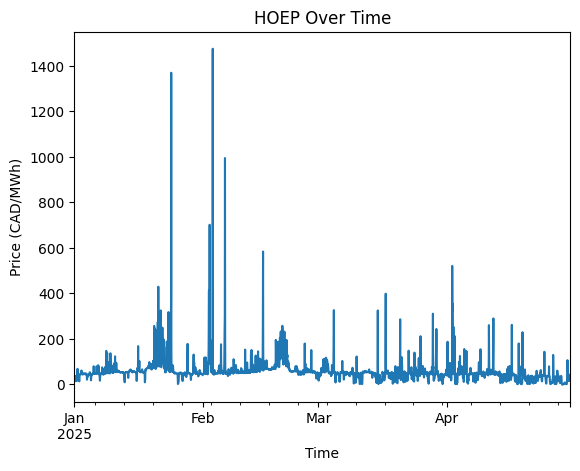

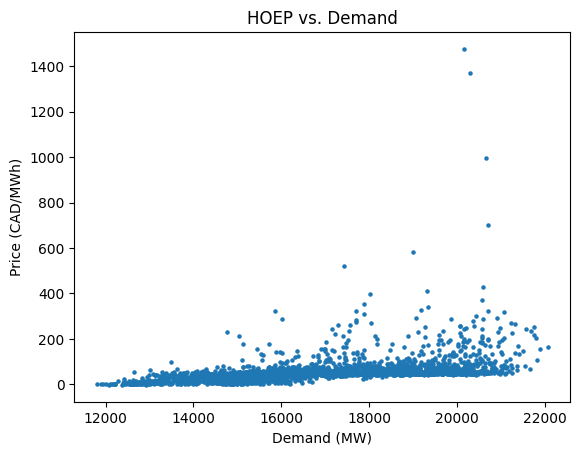

In [3]:
import matplotlib.pyplot as plt

# Price over time
plt.figure()
df.set_index('timestamp')['HOEP'].plot(title='HOEP Over Time')
plt.xlabel('Time')
plt.ylabel('Price (CAD/MWh)')
plt.show()

# Demand vs. Price scatter
plt.figure()
plt.scatter(df['Demand'], df['HOEP'], s=5)
plt.title('HOEP vs. Demand')
plt.xlabel('Demand (MW)')
plt.ylabel('Price (CAD/MWh)')
plt.show()




MSE: 684.8163598772067


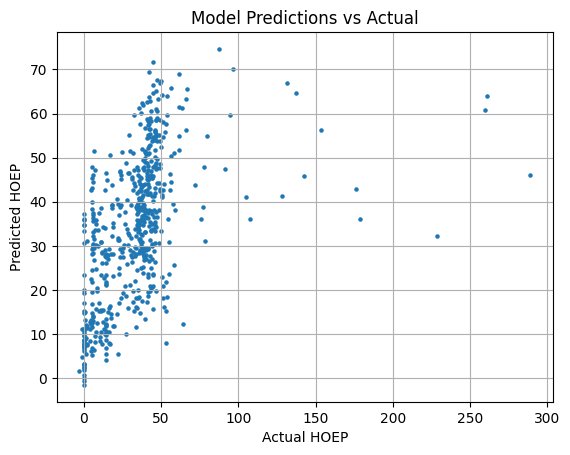

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Feature and label
X = df[['Demand']]
y = df['HOEP']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
plt.scatter(y_test, y_pred, s=5)
plt.xlabel("Actual HOEP")
plt.ylabel("Predicted HOEP")
plt.title("Model Predictions vs Actual")
plt.grid(True)
plt.show()

In [ ]:

# Add datetime features
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Define which extra columns we want from price_df
extra_cols = ['Hour 1 Predispatch', 'OR 10 Min Sync', 'OR 30 Min', 'Hour']

# Merge on timestamp using price_df
df = df.merge(price_df[['timestamp'] + extra_cols], on='timestamp', how='left')

# Drop rows with any NaNs in features or target column
required_cols = ['HOEP', 'Demand'] + extra_cols + ['dayofweek', 'month']
df = df.dropna(subset=required_cols)

# Preview cleaned DataFrame
display(df.head())


,timestamp,HOEP,Demand,dayofweek,month,Hour 1 Predispatch,OR 10 Min Sync,OR 30 Min,Hour
0,2025-01-01 00:00:00,21.31,14098,2,1,20.40,0.98,0.16,1
1,2025-01-01 01:00:00,26.23,13842,2,1,26.00,1.00,0.16,2
2,2025-01-01 02:00:00,32.00,13707,2,1,36.48,1.27,0.16,3
3,2025-01-01 03:00:00,13.03,13626,2,1,35.37,1.19,0.15,4
4,2025-01-01 04:00:00,14.40,13673,2,1,22.22,1.11,0.15,5


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

features = ['Hour','Demand','dayofweek','month','Hour 1 Predispatch','OR 10 Min Sync','OR 30 Min']

X = df[features]
y = df['HOEP']

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred= model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f} CAD/MWh")




ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values